In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from sklearn.preprocessing import PowerTransformer


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Funções de suporte




In [ ]:
def check_stationarity(series: pd.Series, seasonal_period: int = None, alpha: float = 0.05):
    """
    Check stationarity of a time series using the Augmented Dickey-Fuller test.
    Optionally handle seasonal differencing.

    Parameters:
        series (pd.Series): The input time series.
        seasonal_period (int, optional): Seasonal period (e.g., 12 for monthly).
        alpha (float): Significance level for ADF test.

    Returns:
        dict: {
            'adf_stat': float,
            'p_value': float,
            'stationary': bool,
            'diffs_needed': int,
            'seasonal_diffs_needed': int
        }
    """
    def is_stationary(y):
        result = adfuller(y, autolag='AIC')
        return result[0], result[1], result[1] < alpha

    y = series.dropna()
    if isinstance(series, pd.DataFrame):
        y = series.iloc[:, 0]

    # Check original series
    adf_stat, p_val, stationary = is_stationary(y)
    if stationary:
        return {
            'adf_stat': adf_stat,
            'p_value': p_val,
            'stationary': True,
            'diffs_needed': 0,
            'seasonal_diffs_needed': 0
        }

    # Seasonal differencing
    seasonal_diffs = 0
    if seasonal_period:
        for s in range(1, 3):  # try 1 or 2 seasonal diffs
            y_seasonal = y.diff(seasonal_period * s).dropna()
            adf_stat, p_val, stationary = is_stationary(y_seasonal)
            if stationary:
                return {
                    'adf_stat': adf_stat,
                    'p_value': p_val,
                    'stationary': True,
                    'diffs_needed': 0,
                    'seasonal_diffs_needed': s
                }

    # Try both seasonal + regular differencing
    if seasonal_period:
        y_combo = y.copy()
        for s in range(1, 3):
            for d in range(1, 3):
                y_combo = y.diff(seasonal_period * s).dropna().diff(d).dropna()
                adf_stat, p_val, stationary = is_stationary(y_combo)
                if stationary:
                    return {
                        'adf_stat': adf_stat,
                        'p_value': p_val,
                        'stationary': True,
                        'diffs_needed': d,
                        'seasonal_diffs_needed': s
                    }

    # Regular differencing
    diffs = 0
    y_diff = y.copy()
    while diffs < 3:
        y_diff = y_diff.diff().dropna()
        adf_stat, p_val, stationary = is_stationary(y_diff)
        diffs += 1
        if stationary:
            return {
                'adf_stat': adf_stat,
                'p_value': p_val,
                'stationary': True,
                'diffs_needed': diffs,
                'seasonal_diffs_needed': 0
            }


    # If nothing worked
    return {
        'adf_stat': adf_stat,
        'p_value': p_val,
        'stationary': False,
        'diffs_needed': diffs,
        'seasonal_diffs_needed': seasonal_diffs
    }


In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from multiprocessing import Pool, cpu_count
from typing import Union
from tqdm.notebook import tqdm

# Define your function to run in parallel
def fit_sarima(args):
    endog, order, d, D, s, seasonal = args
    try:
          model = SARIMAX(
              endog,
              order=(order[0], d, order[1]),
              seasonal_order=(order[2], D, order[3], s),
              simple_differencing=False
          ).fit(disp=False)
          return (order, model.aic)
    except:
        return None

def optimize_SARIMA_parallel(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    args_list = [(endog, order, d, D, s) for order in order_list]
    print(cpu_count())
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(fit_sarima, args_list), total=len(order_list)))

    # Filter out failed attempts (None)
    results = [res for res in results if res is not None]

    result_df = pd.DataFrame(results, columns=['(p,q,P,Q)', 'AIC'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
import numpy as np

def check_white_noise(residuals: pd.Series, lags: int = 20, alpha: float = 0.05):
    """
    Check if residuals and squared residuals are white noise using the Ljung-Box test.

    Parameters:
        residuals (pd.Series): Residuals from a model.
        lags (int): Number of lags to test.
        alpha (float): Significance level.

    Returns:
        dict: {
            'residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            },
            'squared_residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            }
        }
    """
    # Drop NaNs just in case
    residuals = pd.Series(residuals).dropna()
    squared_residuals = residuals**2

    # Ljung-Box on residuals
    lb_resid = acorr_ljungbox(residuals, lags=lags, return_df=True)
    resid_pvals = lb_resid['lb_pvalue']
    resid_failed = (resid_pvals < alpha).sum()

    # Ljung-Box on squared residuals
    lb_sq = acorr_ljungbox(squared_residuals, lags=lags, return_df=True)
    sq_pvals = lb_sq['lb_pvalue']
    sq_failed = (sq_pvals < alpha).sum()

    return {
        'residuals': {
            'p_values': resid_pvals,
            'lags_failed': resid_failed
        },
        'squared_residuals': {
            'p_values': sq_pvals,
            'lags_failed': sq_failed
        }
    }


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_model_mape(test_df, actual_col, pred_cols, title="Model Comparison (MAPE %)"):
    """
    Plots a bar chart of MAPE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    mape_scores = [mape(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, mape_scores, width=0.6,  edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('MAPE (%)')
    ax.set_ylim(0, max(mape_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(mape_scores):
        ax.text(i, val + 0.5, f"{val:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, mape_scores))


In [ ]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_model_rmse(test_df, actual_col, pred_cols, title="Model Comparison (RMSE)"):
    """
    Plots a bar chart of RMSE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    rmse_scores = [rmse(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, rmse_scores, width=0.6, color='lightcoral', edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('RMSE')
    ax.set_ylim(0, max(rmse_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(rmse_scores):
        ax.text(i, val + max(rmse_scores) * 0.03, f"{val:.4f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, rmse_scores))


# SELEÇÃO DE MODELO


## Carregamento e visualização inicial da série

In [ ]:
df = pd.read_excel('/content/DadosCompeticao.xlsx', decimal=',')
serie_8 = df.iloc[:, 7]
serie_8.head()

,#8
0,0.031778
1,0.000000
2,0.067337
3,0.095552
4,0.074454


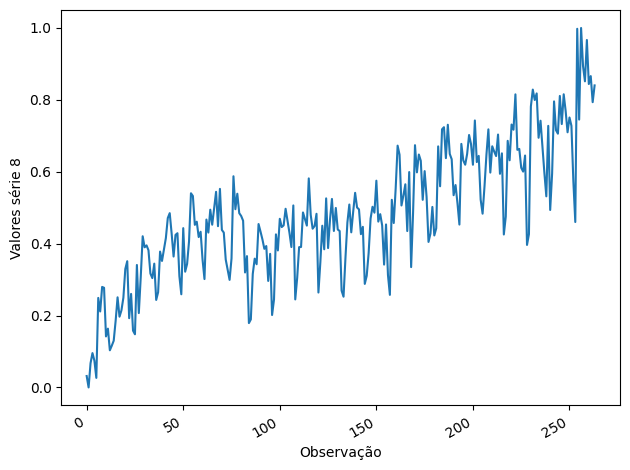

In [ ]:
fig, ax = plt.subplots()

ax.plot(serie_8)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores série 8')

fig.autofmt_xdate()
plt.tight_layout()


## Busca por sinais de sazonalidade

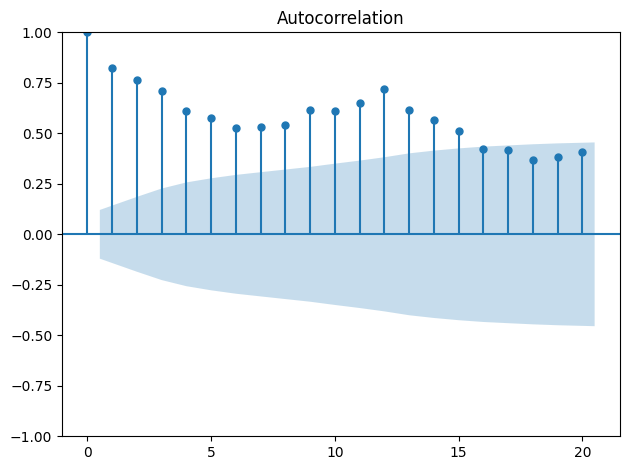

In [ ]:
plot_acf(serie_8, lags=20);
plt.tight_layout()

In [ ]:
advanced_decomposition = STL(serie_8,period=12).fit()

## Conjunto de treino

In [ ]:
test = pd.DataFrame()
test["Values"] = serie_8.iloc[-12:]
test['naive_seasonal'] = serie_8.iloc[-24:-12].values
test['naive_seasonal-A'] = serie_8.iloc[-24:-12].mean()

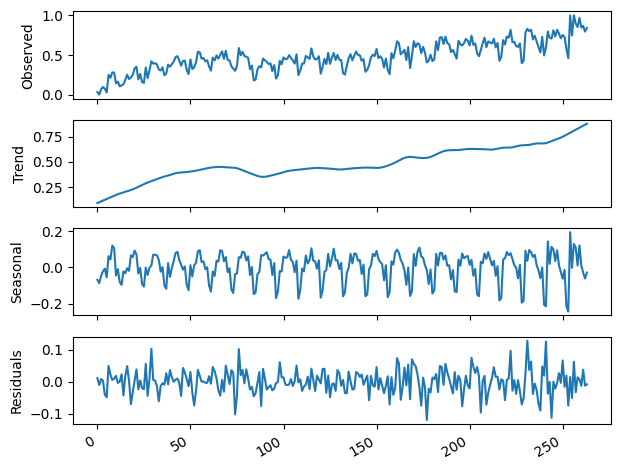

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

## SARIMA

In [ ]:
check_stationarity(serie_8.diff().dropna(),seasonal_period=12)

{'adf_stat': -3.9740397070769102,
 'p_value': 0.001552716625435438,
 'stationary': True,
 'diffs_needed': 0,
 'seasonal_diffs_needed': 0}

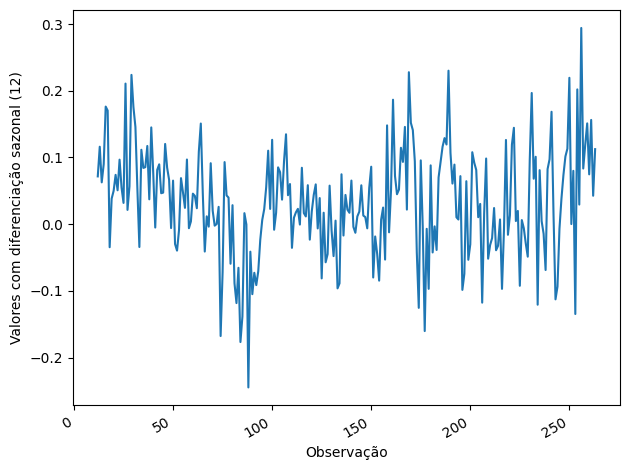

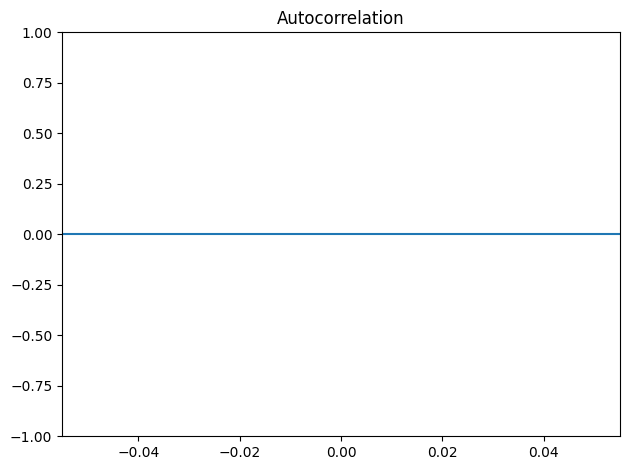

In [ ]:
seasonal_diff = serie_8.diff(12)
fig, ax = plt.subplots()

ax.plot(seasonal_diff)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores com diferenciação sazonal (12)')

fig.autofmt_xdate()
plt.tight_layout()
plot_acf(seasonal_diff, lags=24);
plt.tight_layout()

### Treinamento

In [ ]:
train = serie_8[:-12]
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)


```
 from itertools import product

 ps = range(0, 5)
 qs = range(0, 5)
 Ps = range(0, 5)
 Qs = range(0, 5)

 SARIMA_order_list = list(product(ps, qs, Ps, Qs))

 train = serie_1[:-12]

 d = 1
 D = 0
 s = 12

 SARIMA_result_df = optimize_SARIMA_parallel(train, SARIMA_order_list, d, D, s)
 SARIMA_result_df
 */

```
Modelos selecionados:  \\

* ARIMA(10,1,11) | AIC = -585.001871 \\
* SARIMA(1,1,1)(3,1,3,12) | AIC = -599.327503


In [ ]:
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)

ARIMA_model = SARIMAX(train_transformed, order=(10,1,11), seasonal_order=(0,0,0,0), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)


SARIMA_model = SARIMAX(train_transformed, order=(1,1,1), seasonal_order=(3,1,3,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

In [ ]:
forecast_ARIMA = ARIMA_model_fit.forecast(steps=12)
test['ARIMA_pred'] = pt.inverse_transform(forecast_ARIMA.values.reshape(-1, 1)).flatten()
forecast_SARIMA = SARIMA_model_fit.forecast(steps=12)
test['SARIMA_pred'] = pt.inverse_transform(forecast_SARIMA.values.reshape(-1, 1)).flatten()


In [ ]:
test

,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred
252,0.573545,0.493651,0.718607,0.570807,0.594220
253,0.460195,0.594919,0.718607,0.656736,0.619482
254,0.997725,0.795737,0.718607,0.815972,0.799482
255,0.745169,0.715802,0.718607,0.761232,0.755549
256,1.000000,0.705916,0.718607,0.872190,0.800903
257,0.894296,0.810930,0.718607,0.808480,0.796579
258,0.851575,0.732732,0.718607,0.780482,0.792774
259,0.966583,0.815523,0.718607,0.845987,0.844315
260,0.844078,0.769438,0.718607,0.732699,0.779359
261,0.866046,0.709824,0.718607,0.700591,0.796533


### Análise de resíduos

In [ ]:
check_white_noise(ARIMA_model_fit.resid, lags = 24)

{'residuals': {'p_values': 1     0.675702
  2     0.904540
  3     0.927613
  4     0.859348
  5     0.915244
  6     0.720974
  7     0.805844
  8     0.877240
  9     0.892112
  10    0.932743
  11    0.923020
  12    0.933593
  13    0.938177
  14    0.957198
  15    0.970158
  16    0.921976
  17    0.890344
  18    0.846456
  19    0.839276
  20    0.700194
  21    0.736590
  22    0.786268
  23    0.805210
  24    0.742727
  Name: lb_pvalue, dtype: float64,
  'lags_failed': 0},
 'squared_residuals': {'p_values': 1     0.667853
  2     0.668222
  3     0.154409
  4     0.111286
  5     0.144812
  6     0.219950
  7     0.305738
  8     0.079835
  9     0.113024
  10    0.121667
  11    0.158801
  12    0.172266
  13    0.189014
  14    0.244032
  15    0.299223
  16    0.341170
  17    0.332034
  18    0.377100
  19    0.437811
  20    0.390096
  21    0.443267
  22    0.389889
  23    0.390439
  24    0.438919
  Name: lb_pvalue, dtype: float64,
  'lags_failed': 0}}

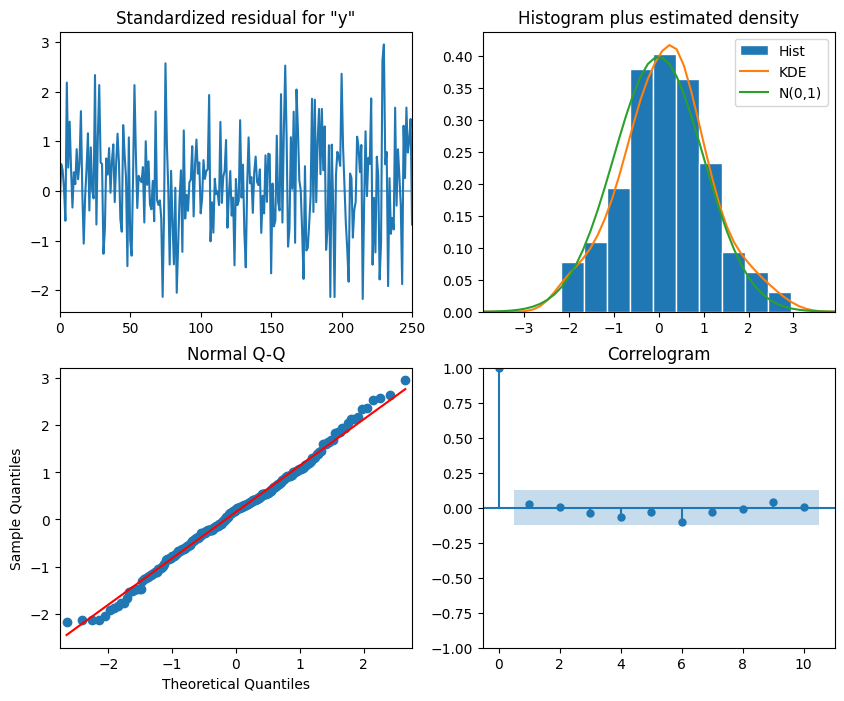

In [ ]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [ ]:
check_white_noise(SARIMA_model_fit.resid, lags = 12)

{'residuals': {'p_values': 1     0.442674
  2     0.723266
  3     0.614649
  4     0.755163
  5     0.812703
  6     0.890438
  7     0.828162
  8     0.854925
  9     0.522529
  10    0.611779
  11    0.664731
  12    0.699933
  Name: lb_pvalue, dtype: float64,
  'lags_failed': 0},
 'squared_residuals': {'p_values': 1     0.308272
  2     0.505250
  3     0.379963
  4     0.445920
  5     0.568782
  6     0.685020
  7     0.785231
  8     0.038772
  9     0.035830
  10    0.048999
  11    0.072016
  12    0.069641
  Name: lb_pvalue, dtype: float64,
  'lags_failed': 3}}

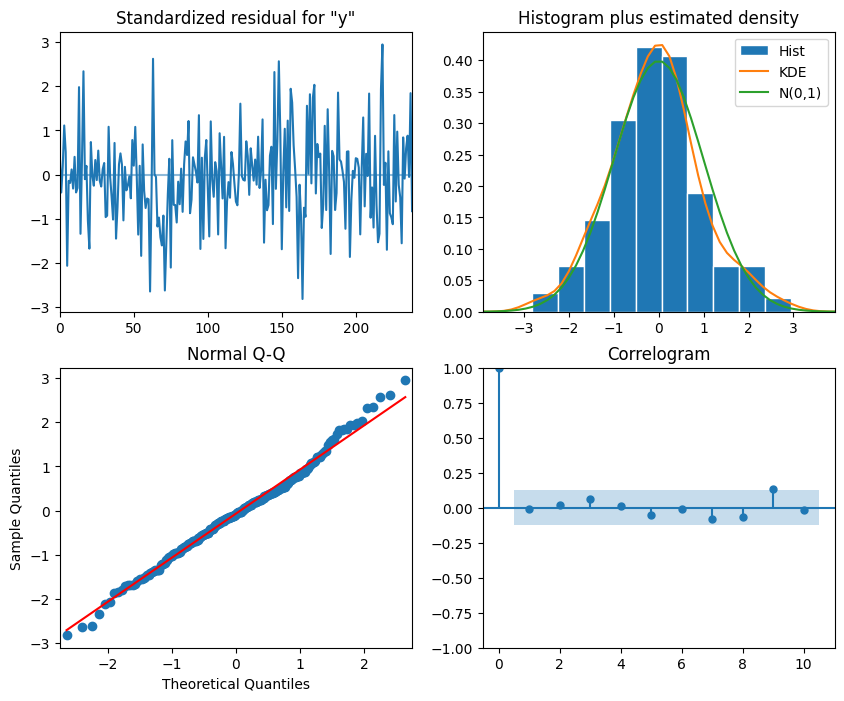

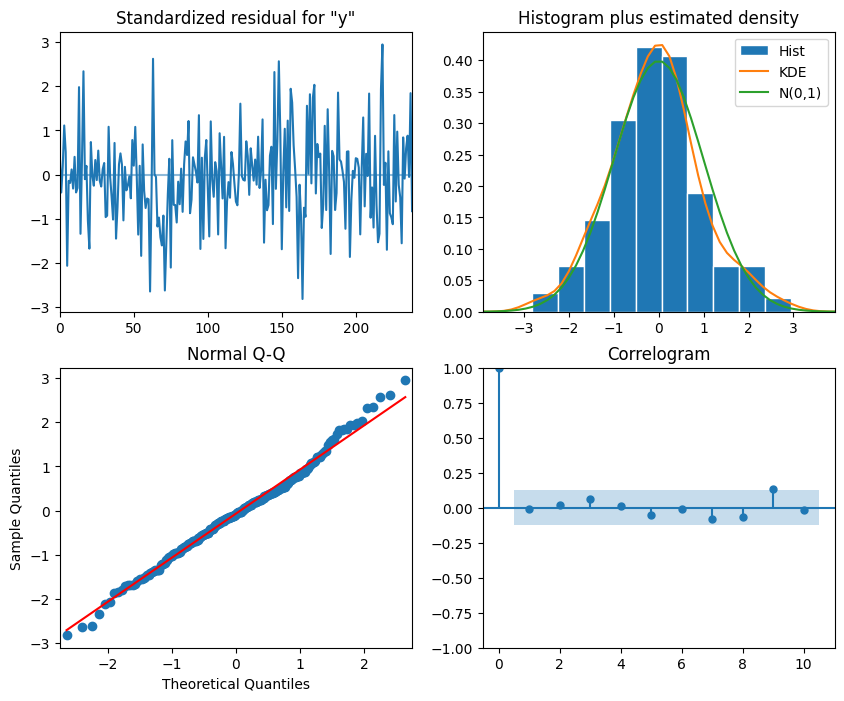

In [ ]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

## Holt-Winters

### Treinamento

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import PowerTransformer
import pandas as pd
import numpy as np

train = serie_8[:-12]
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)
ES = ExponentialSmoothing(train_transformed,trend='add', damped_trend=True)
ES_fit = ES.fit()
forecast_1 =  pt.inverse_transform(ES_fit.forecast(12).values.reshape(-1, 1)).flatten()

ES3 = ExponentialSmoothing(train, trend='add')
ES3_fit = ES3.fit()

test["HW"] = forecast_1
test["HW_P"] = ES3_fit.forecast(12).values
test


,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred,HW,HW_P
252,0.573545,0.493651,0.718607,0.570807,0.594220,0.735036,0.739578
253,0.460195,0.594919,0.718607,0.656736,0.619482,0.735036,0.742399
254,0.997725,0.795737,0.718607,0.815972,0.799482,0.735036,0.745219
255,0.745169,0.715802,0.718607,0.761232,0.755549,0.735036,0.748039
256,1.000000,0.705916,0.718607,0.872190,0.800903,0.735037,0.750860
257,0.894296,0.810930,0.718607,0.808480,0.796579,0.735037,0.753680
258,0.851575,0.732732,0.718607,0.780482,0.792774,0.735037,0.756500
259,0.966583,0.815523,0.718607,0.845987,0.844315,0.735037,0.759321
260,0.844078,0.769438,0.718607,0.732699,0.779359,0.735037,0.762141
261,0.866046,0.709824,0.718607,0.700591,0.796533,0.735037,0.764961


In [ ]:
print("Residuos 1:" + str(check_white_noise(ES_fit.resid)))

Residuos 1:{'residuals': {'p_values': 1     7.013604e-01
2     8.404020e-01
3     6.098002e-01
4     8.511072e-04
5     1.200687e-04
6     4.066397e-08
7     5.732178e-10
8     7.477895e-11
9     3.222769e-11
10    9.273587e-11
11    3.507837e-11
12    3.736774e-30
13    1.079600e-29
14    2.551440e-29
15    8.953787e-29
16    1.047291e-32
17    2.587654e-32
18    9.978661e-37
19    2.248109e-37
20    5.944013e-37
Name: lb_pvalue, dtype: float64, 'lags_failed': 17}, 'squared_residuals': {'p_values': 1     3.290830e-01
2     1.153981e-03
3     3.165032e-03
4     7.341657e-03
5     9.709853e-03
6     1.224634e-02
7     2.241983e-02
8     2.811789e-02
9     4.555249e-02
10    1.101927e-02
11    1.265736e-02
12    1.418903e-11
13    8.145612e-12
14    1.067886e-14
15    1.264420e-14
16    3.287089e-14
17    3.442009e-14
18    1.681195e-14
19    2.579552e-14
20    5.465431e-14
Name: lb_pvalue, dtype: float64, 'lags_failed': 19}}


In [ ]:
ES_fit.summary()

Dep. Variable:,None,No. Observations:,252
Model:,ExponentialSmoothing,SSE,2.734
Optimized:,True,AIC,-1129.979
Trend:,Additive,BIC,-1112.332
Seasonal:,None,AICC,-1129.520
Seasonal Periods:,None,Date:,"Tue, 29 Apr 2025"
Box-Cox:,False,Time:,17:55:53
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5907856,alpha,True
smoothing_trend,6.8484e-16,beta,True


## Theta

In [ ]:
from statsmodels.tsa.forecasting.theta import ThetaModel

pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)

# Fit the Theta model
theta_model = ThetaModel(train_transformed,period=12)
theta_fit = theta_model.fit()

# Forecast future values
theta_forecast = theta_fit.forecast(steps=12)
test["Theta"] = pt.inverse_transform(theta_forecast.values.reshape(-1, 1)).flatten()
# Print results
print(theta_fit.summary())
print("Forecast:", theta_forecast)

                              ThetaModel Results                              
Dep. Variable:                  endog   No. Observations:                  252
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Tue, 29 Apr 2025   Deseas. Method:               Additive
Time:                        17:55:54   Period:                             12
Sample:                             0                                         
                                  252                                         
    Parameter Estimates    
            Parameters     
---------------------------
b0    0.0021480627092289833
alpha    0.3616567927200177
---------------------------
Forecast: 252    0.655672
253    0.670665
254    0.844738
255    0.821570
256    0.896810
257    0.894377
258    0.912702
259    0.913172
260    0.872693
261    0.865470
262    0.782037
263    0.844464
Name: forecast, dtype: float64


## Visualização das predições


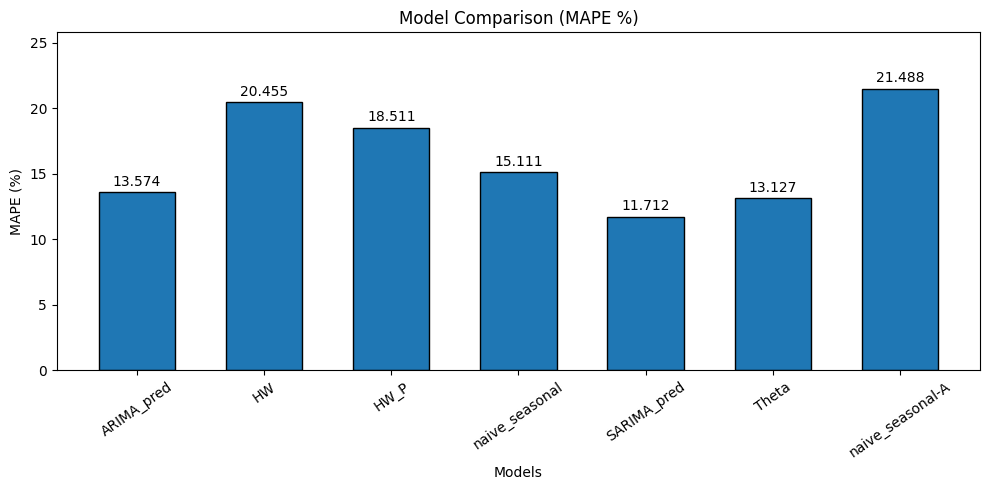

{'ARIMA_pred': 13.573785388512352,
 'HW': 20.454545467304005,
 'HW_P': 18.51053631805947,
 'naive_seasonal': 15.110941879593035,
 'SARIMA_pred': 11.711968400154307,
 'Theta': 13.126780305291494,
 'naive_seasonal-A': 21.487540741641794}

In [ ]:
columns = ['ARIMA_pred','HW','HW_P','naive_seasonal','SARIMA_pred','Theta','naive_seasonal-A']
plot_model_mape(test,'Values',columns)

In [ ]:
test

,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred,HW,HW_P,Theta
252,0.573545,0.493651,0.718607,0.570807,0.594220,0.735036,0.739578,0.596262
253,0.460195,0.594919,0.718607,0.656736,0.619482,0.735036,0.742399,0.608842
254,0.997725,0.795737,0.718607,0.815972,0.799482,0.735036,0.745219,0.752356
255,0.745169,0.715802,0.718607,0.761232,0.755549,0.735036,0.748039,0.733514
256,1.000000,0.705916,0.718607,0.872190,0.800903,0.735037,0.750860,0.794434
257,0.894296,0.810930,0.718607,0.808480,0.796579,0.735037,0.753680,0.792476
258,0.851575,0.732732,0.718607,0.780482,0.792774,0.735037,0.756500,0.807203
259,0.966583,0.815523,0.718607,0.845987,0.844315,0.735037,0.759321,0.807580
260,0.844078,0.769438,0.718607,0.732699,0.779359,0.735037,0.762141,0.774992
261,0.866046,0.709824,0.718607,0.700591,0.796533,0.735037,0.764961,0.769154


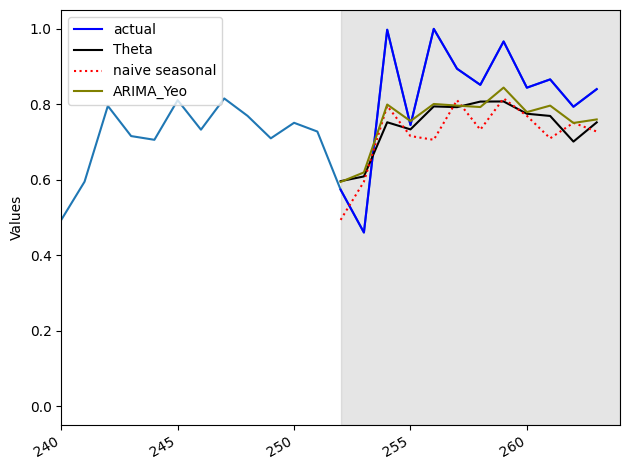

In [ ]:
fig, ax = plt.subplots()

ax.plot(serie_8)
ax.plot(test["Values"], 'b-', label='actual')
#ax.plot(test['ARIMA_pred'], 'g-.', label='ARIMA')
#ax.plot(test['HW'], 'cyan', label='ES')
ax.plot(test['Theta'], 'black', label='Theta')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['SARIMA_pred'], 'olive', label='ARIMA_Yeo')
#ax.plot(test['HW_P'], 'tan', label='ES-Y')
#ax.plot(test['naive_seasonal-A'] , 'lavender', label='Mean')

ax.set_ylabel('Values')
ax.axvspan(252, 264, color='#808080', alpha=0.2)

ax.legend(loc=2)

ax.set_xlim(240, 264)

fig.autofmt_xdate()
plt.tight_layout()

## Melhoramento de resíduos

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import PowerTransformer

# ----- Configurações -----
seasonal_period = 12
horizon = 12
lags = 12

# ----- Série original -----
train = serie_8.iloc[:-horizon]

# ----- Reutilizar o PowerTransformer treinado anteriormente -----
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)

# ----- Previsão SARIMA (em escala transformada) -----
SARIMA_forecast_transformed = SARIMA_model_fit.forecast(steps=horizon)
fitted_SARIMA_transformed = SARIMA_model_fit.fittedvalues

# ----- Inverter previsão para a escala original -----
SARIMA_forecast_diff = pt.inverse_transform(SARIMA_forecast_transformed.values.reshape(-1, 1)).flatten()
fitted_SARIMA = pt.inverse_transform(fitted_SARIMA_transformed.values.reshape(-1, 1)).flatten()

# ----- Calcular resíduos (escala original, sem nova transformação) -----
residuals_index = fitted_SARIMA_transformed.index
residuals = train.loc[residuals_index] - fitted_SARIMA
train_transformed = pd.Series(residuals, index=train.index)
residuals = pd.Series(residuals, index=residuals_index).dropna()

# ----- Ajustar ARIMA diretamente nos resíduos (sem Yeo-Johnson) -----
residuals_arima_order = (5, 0, 5)  # ajuste conforme necessário
residuals_model = ARIMA(train_transformed, order=residuals_arima_order)
residuals_model_fit = residuals_model.fit()

# ----- Previsão dos resíduos -----
res_forecast = residuals_model_fit.forecast(steps=horizon)

# ----- Forecast híbrido -----
hybrid_diff = SARIMA_forecast_diff + pt.inverse_transform(res_forecast.values.reshape(-1, 1)).flatten()
test["SARIMA + Residual ARIMA"] = hybrid_diff

test


,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred,HW,HW_P,Theta,SARIMA + Residual ARIMA
252,0.573545,0.493651,0.718607,0.570807,0.594220,0.735036,0.739578,0.596262,0.593645
253,0.460195,0.594919,0.718607,0.656736,0.619482,0.735036,0.742399,0.608842,0.616349
254,0.997725,0.795737,0.718607,0.815972,0.799482,0.735036,0.745219,0.752356,0.791266
255,0.745169,0.715802,0.718607,0.761232,0.755549,0.735036,0.748039,0.733514,0.750847
256,1.000000,0.705916,0.718607,0.872190,0.800903,0.735037,0.750860,0.794434,0.799911
257,0.894296,0.810930,0.718607,0.808480,0.796579,0.735037,0.753680,0.792476,0.792649
258,0.851575,0.732732,0.718607,0.780482,0.792774,0.735037,0.756500,0.807203,0.790489
259,0.966583,0.815523,0.718607,0.845987,0.844315,0.735037,0.759321,0.807580,0.840857
260,0.844078,0.769438,0.718607,0.732699,0.779359,0.735037,0.762141,0.774992,0.774694
261,0.866046,0.709824,0.718607,0.700591,0.796533,0.735037,0.764961,0.769154,0.791581


## Métricas finais

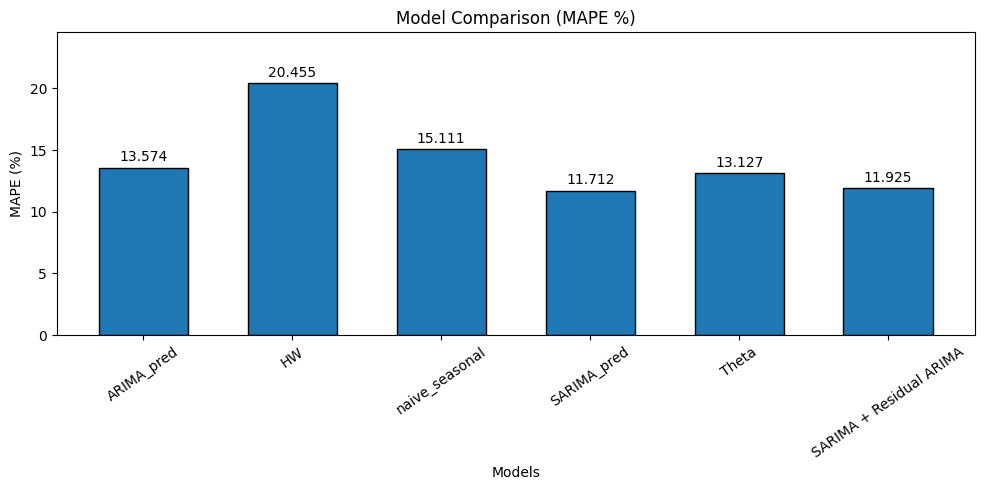

{'ARIMA_pred': 13.573785388512352,
 'HW': 20.454545467304005,
 'naive_seasonal': 15.110941879593035,
 'SARIMA_pred': 11.711968400154307,
 'Theta': 13.126780305291494,
 'SARIMA + Residual ARIMA': 11.925387993165206}

In [ ]:
columns = ['ARIMA_pred','HW','naive_seasonal','SARIMA_pred','Theta','SARIMA + Residual ARIMA']
plot_model_mape(test,'Values',columns)

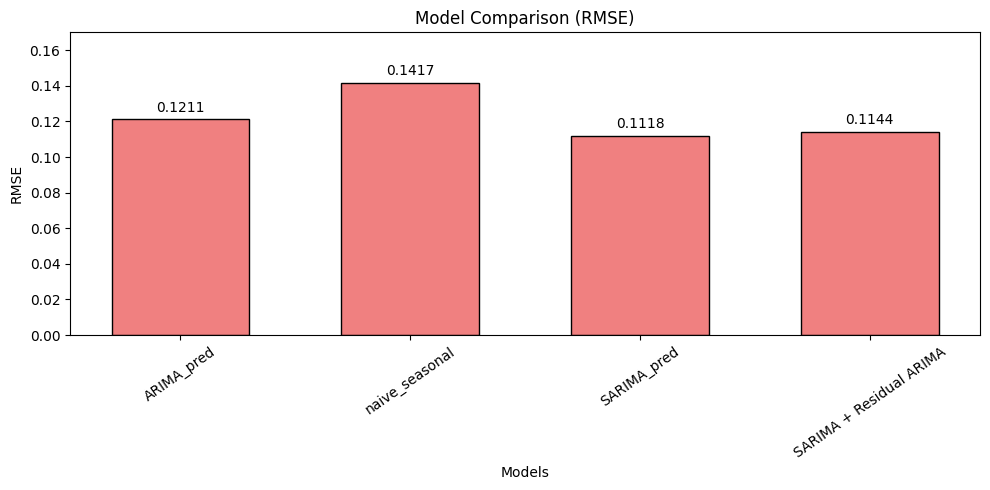

In [ ]:
columns_to_plot = ['ARIMA_pred','naive_seasonal','SARIMA_pred','SARIMA + Residual ARIMA']

rmse_results = plot_model_rmse(test, 'Values', columns_to_plot)

# Previsão para a série (próximos 12 meses)

In [ ]:
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(serie_8.values.reshape(-1, 1)).flatten(), index=serie_8.index)


SARIMA_model = SARIMAX(train_transformed, order=(1,1,1), seasonal_order=(3,1,3,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

forecast_steps = 12
forecast_SARIMA = SARIMA_model_fit.forecast(steps=forecast_steps)

forecast_original_scale = pt.inverse_transform(forecast_SARIMA.values.reshape(-1, 1)).flatten()

forecast_original_scale


array([0.69225853, 0.6617458 , 0.96309697, 0.86151106, 0.98321684,
       0.94158767, 0.95842246, 0.95062681, 0.89491927, 0.91280777,
       0.84001773, 0.8853755 ])

In [ ]:
forecast_original_scale

array([0.69225853, 0.6617458 , 0.96309697, 0.86151106, 0.98321684,
       0.94158767, 0.95842246, 0.95062681, 0.89491927, 0.91280777,
       0.84001773, 0.8853755 ])

In [ ]:
# ----- Salvando previsões numeradas em um .txt -----
horizon = len(forecast_original_scale)

with open("8.csv", "w") as f:
    for i, value in enumerate(forecast_original_scale, 1):
        f.write(f"{i}: {value:};\n")
